# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

## Imported Libraries

The code imports essential Python libraries for mathematical operations (`math`), regular expressions (`re`), random number generation (`random`), numerical computing (`numpy`), and deep learning with PyTorch (`torch`). Specifically, PyTorch modules for neural networks (`torch.nn`) and optimization (`torch.optim`) are imported. These imports lay the groundwork for various computational tasks, including data manipulation, model building, and optimization.


In [1]:
import os
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Data

### Dataset Features Summary

The provided code snippet loads two datasets using the Hugging Face `datasets` library: SNLI (Stanford Natural Language Inference) and MNLI (Multi-Genre Natural Language Inference). Here's a summary of the features for both datasets:

- **SNLI Dataset Features**:
  - The SNLI dataset is loaded using `datasets.load_dataset('snli')`.
  - The dataset features include:
    - `premise`: Textual premise for the sentence pair.
    - `hypothesis`: Textual hypothesis for the sentence pair.
    - `label`: Ground truth label indicating the relationship between the premise and hypothesis (e.g., entailment, contradiction, or neutral).

- **MNLI Dataset Features**:
  - The MNLI dataset is loaded using `datasets.load_dataset('glue', 'mnli')`.
  - The dataset features for the 'train' split include:
    - `premise`: Textual premise for the sentence pair.
    - `hypothesis`: Textual hypothesis for the sentence pair.
    - `label`: Ground truth label indicating the relationship between the premise and hypothesis, similar to SNLI.

These features provide essential information about the structure of the datasets, which includes textual data for premise and hypothesis, along with corresponding labels for inference tasks.


In [2]:
import datasets
snli = datasets.load_dataset('snli')
mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features, snli['train'].features

/Users/shafisourov/anaconda3/envs/nlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [3]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [4]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [5]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [6]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [7]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [8]:
mnli = mnli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [9]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([0, 1, 2]))

## Merged Dataset Summary

The provided code snippet merges two DatasetDict objects, `snli` and `mnli`, into a single DatasetDict object named `raw_dataset`. Here's a summary of the merged dataset:

- **Train Dataset**:
  - Combined train data from SNLI and MNLI.
  - The dataset has been shuffled.
  - Selected a subset of 85 samples for training.

- **Test Dataset**:
  - Combined test data from SNLI and MNLI mismatched test set.
  - The dataset has been shuffled.
  - Selected a subset of 15 samples for testing.

- **Validation Dataset**:
  - Combined validation data from SNLI and MNLI mismatched validation set.
  - The dataset has been shuffled.
  - Selected a subset of 15 samples for validation.

This merged dataset provides a comprehensive collection of training, testing, and validation samples from both SNLI and MNLI datasets, allowing for a more diverse and robust evaluation of natural language inference models.


In [10]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict
# Merge the two DatasetDict objects
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(85))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(15))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(15)))
})
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 85
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 15
    })
})

## 2. Preprocessing

## Tokenization and Vocabulary Loading

The provided code snippet demonstrates the tokenization process using the `basic_english` tokenizer from `torchtext` and loading a vocabulary from a saved file. Here's a summary:

- **Tokenizer Loading**:
  - Utilizes the `get_tokenizer` function from `torchtext.data.utils` to load the `basic_english` tokenizer.
  - This tokenizer is commonly used for tokenizing text data in English based on basic word boundaries.

- **Vocabulary Loading**:
  - Loads a vocabulary from a saved file named `'vocab.pth'`.
  - The vocabulary is loaded into the variable `vocab`.
  - The vocabulary likely contains mappings from tokens to their corresponding integer indices and vice versa, facilitating tokenization and numerical encoding of text data.

These steps are crucial for preprocessing text data before feeding it into machine learning models, especially for tasks like natural language processing and understanding.


In [11]:
from torchtext.data.utils import get_tokenizer

# Load the 'basic_english' tokenizer
tokenizer = get_tokenizer('basic_english')
vocab = torch.load('./model/vocab.pt')

In [12]:
len(vocab)

93

In [13]:
tokens_to_check = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]', 'the', 'of', 'and']
for token in tokens_to_check:
    print(f"Index of '{token}': {vocab[token]}")

Index of '[PAD]': 0
Index of '[CLS]': 1
Index of '[SEP]': 2
Index of '[MASK]': 3
Index of '[UNK]': 4
Index of 'the': 4
Index of 'of': 4
Index of 'and': 4


In [14]:
import re

sent = "Hello, world! How are you doing today? Let's explore - regex."
cleaned_sent = re.sub("[.,!?\\-]", '', sent.lower())

print(cleaned_sent)


hello world how are you doing today let's explore  regex


### Tokenization and Padding

The provided code snippet showcases tokenization and padding of sentences using a specified tokenizer and vocabulary. Here's a summary:

- **Max Sequence Length**:
  - `max_seq_length` is set to `512`, defining the maximum length for tokenized sequences.

- **Tokenization and Padding Functions**:
  - `tokenize_and_pad(sentences, tokenizer, vocab, max_length=512)`: 
    - Tokenizes the input sentences using the specified `tokenizer`, removes punctuation marks, and converts text to lowercase.
    - Converts tokens to IDs based on the provided `vocab`.
    - Adds special tokens (`[CLS]` and `[SEP]`) at the beginning and end of each tokenized sequence, respectively.
    - Applies padding to ensure all sequences have the same length (`max_length`).
    
- **Preprocess Function** (`preprocess_function(examples)`):
  - Tokenizes and pads both premise and hypothesis sentences using `tokenize_and_pad`.
  - Extracts labels from the examples.

- **Mapping Preprocessing Function**:
  - Applies the `preprocess_function` to the entire dataset in a batched manner using the `map` method.
  - Returns tokenized datasets containing processed input IDs, attention masks, and labels.

- **Dataset Format**:
  - Sets the format of the tokenized datasets to PyTorch tensors using `set_format("torch")`.


In [15]:
max_seq_length = 512

# Example usage before your model.forward() call


def tokenize_and_pad(sentences, tokenizer, vocab, max_length=512):
    # Tokenizes sentences, converts tokens to IDs, adds special tokens, and applies padding
    tokenized = [tokenizer(re.sub("[.,!?\\-]", '', sent.lower())) for sent in sentences]
    input_ids = [[vocab['[CLS]']] + [vocab[token] for token in tokens] + [vocab['[SEP]']] for tokens in tokenized]

    attn_mask = [[1] * len(tokens) + [0] * (max_length - len(tokens)) for tokens in input_ids]
    input_ids = [tokens + [0] * (max_length - len(tokens)) for tokens in input_ids]
    return input_ids, attn_mask



def preprocess_function(examples):
    # Tokenize and pad both premise and hypothesis
    premise_input_ids, premise_attn_mask = tokenize_and_pad(examples['premise'], tokenizer, vocab, max_seq_length)
    hypothesis_input_ids, hypothesis_attn_mask = tokenize_and_pad(examples['hypothesis'], tokenizer, vocab, max_seq_length)
    
    # Extract labels
    labels = examples["label"]
    
    return {
        "premise_input_ids": premise_input_ids,
        "premise_attention_mask": premise_attn_mask,
        "hypothesis_input_ids": hypothesis_input_ids,
        "hypothesis_attention_mask": hypothesis_attn_mask,
        "labels": labels
    }

# Map the preprocessing function across the dataset in a batched manner
tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

# Remove the original columns to focus on the processed ones and set the format to PyTorch tensors
# tokenized_datasets = tokenized_datasets.remove_columns(['premise', 'hypothesis', 'label'])
tokenized_datasets.set_format("torch")


## 3. Data loader

## Data Loading with PyTorch DataLoader

The provided code snippet demonstrates how to initialize PyTorch `DataLoader` objects for training, evaluation, and testing. Here's a summary:

- **Batch Size**:
  - `batch_size` is set to `5`, specifying the number of samples per batch.

- **Train DataLoader** (`train_dataloader`):
  - Initializes a `DataLoader` for the training dataset (`tokenized_datasets['train']`).
  - `batch_size` is set to the specified value.
  - `shuffle` is set to `True` to shuffle the data during training.

- **Evaluation DataLoader** (`eval_dataloader`):
  - Initializes a `DataLoader` for the validation dataset (`tokenized_datasets['validation']`).
  - `batch_size` is set to the specified value.
  - Data is not shuffled during evaluation.

- **Test DataLoader** (`test_dataloader`):
  - Initializes a `DataLoader` for the test dataset (`tokenized_datasets['test']`).
  - `batch_size` is set to the specified value.
  - Data is not shuffled during testing.


In [16]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 5
train_dataloader = DataLoader(
    tokenized_datasets['train'], 
    batch_size=batch_size, 
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], 
    batch_size=batch_size
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], 
    batch_size=batch_size
)

In [17]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([5, 512])
torch.Size([5, 512])
torch.Size([5, 512])
torch.Size([5, 512])
torch.Size([5])


## 4. Model

### Model Loading and Summary

The provided code snippet loads a pre-trained BERT model along with its hyperparameters. Here's a summary of the process:

1. **Loading Pre-trained BERT Model**:
   - A custom BERT model is initialized using the `BERT` class from the `model_class.py` module.
   - The model's hyperparameters are loaded from the specified file (`./model/bert_best_model.pt`).
   - The model is loaded onto the specified device (`device`).

2. **Markdown Summary**:
   - The markdown summary of the code execution is to be provided. This summary will likely include details about the loaded BERT model and its hyperparameters, as well as any other relevant information about the model loading process.

Please note that the specific details of the BERT model and its hyperparameters are not provided in the code snippet and would need to be extracted from the loaded parameters and configuration.


In [18]:
# # start from a pretrained bert-base-uncased model
from model_class import *

# load the model and all its hyperparameters
load_path = './model/bert_best_model.pt'
params, state = torch.load(load_path)
model = BERT(**params, device=device).to(device)
model.load_state_dict(state)

<All keys matched successfully>

In [19]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

37073759


### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

## Mean Pooling Function Definition

The provided code defines a function for mean pooling token embeddings. Here's a summary of the function:

- **Function Name**: `mean_pool`
- **Arguments**:
  - `token_embeds`: Tensor containing token embeddings of shape `[batch_size, seq_length, embed_dim]`.
  - `attention_mask`: Tensor containing attention mask of shape `[batch_size, seq_length]`, where padding tokens are masked with 0 and non-padding tokens are masked with 1.
- **Functionality**:
  - Reshapes the attention mask to cover the 768-dimensional embeddings.
  - Performs mean-pooling across the token embeddings, excluding the padding tokens specified by the attention mask.
  - Returns the mean-pooled representation of the token embeddings.

This function can be useful for aggregating token embeddings into a single representation, often used in tasks such as sentence classification or semantic similarity.


In [20]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

## 5. Loss Function

## Classification Objective Function 
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function. 
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)

<img src="./figures/sbert-architecture.png" >

## Function Definitions: Configurations and Cosine Similarity

In [21]:
def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    
    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

<img src="./figures/sbert-ablation.png" width="350" height="300">

## Model Initialization and Optimizers

In [22]:
classifier_head = torch.nn.Linear(768*3, 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

## Learning Rate Schedulers with Warmup

In [23]:
from transformers import get_linear_schedule_with_warmup

# and setup a warmup for the first ~10% steps
total_steps = int(len(raw_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optimizer, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler.step()

scheduler_classifier = get_linear_schedule_with_warmup(
		optimizer_classifier, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler_classifier.step()

/Users/shafisourov/anaconda3/envs/nlu/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## 6. Training

## Training Function Overview

The `train` function is designed to train a BERT-based model with a classifier head. It follows a structured approach to process the data, compute predictions, calculate losses, and update model parameters. Below is an overview of the key steps performed by the `train` function:

### Data Preparation
1. Tokenization: The input sequences are tokenized using the BERT tokenizer.
2. Device Transfer: Tensors are moved to the active device for computation.

### Model Forward Pass
1. Token Embeddings Extraction: Token embeddings are extracted from the BERT model for both input sequences.
2. Mean Pooling: Mean-pooled representations are computed for each sequence.
3. Concatenation: The mean-pooled representations are concatenated with their absolute difference.

### Classifier Head Operation
1. Forward Pass: The concatenated representations are passed through the classifier head to obtain predictions.
2. Loss Calculation: The cross-entropy loss is computed between the predicted and true labels.

### Backpropagation and Optimization
1. Gradients Calculation: Gradients with respect to the loss are computed.
2. Parameter Update: Model parameters are updated using the optimizer.
3. Learning Rate Adjustment: Learning rate is updated using the scheduler.

Overall, the `train` function efficiently handles the training process, ensuring proper data processing, model computation, and parameter optimization.



In [24]:
from tqdm.auto import tqdm

def train(model, classifier_head, data, optimizer, optimizer_classifier, scheduler, scheduler_classifier, criterion, device):
    epoch_loss = []
    model.train()
    classifier_head.train()

    for step, batch in enumerate(tqdm(data, leave=True, desc='Training: ')):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        segment_ids = torch.zeros(batch_size, max_seq_length, dtype=torch.int32).to(device)  # each input contains only one sentence hence we define them all as sentence '0'
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u_last_hidden_state = model.get_last_hidden_state(inputs_ids_a, segment_ids)  
        v_last_hidden_state = model.get_last_hidden_state(inputs_ids_b, segment_ids)  

        # u_last_hidden_state = u.last_hidden_state # all token embeddings A = batch_size, seq_len, hidden_dim
        # v_last_hidden_state = v.last_hidden_state # all token embeddings B = batch_size, seq_len, hidden_dim

         # get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim
        
        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim
        
        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim
        
        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        
        # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, label)
        
        # using loss, calculate gradients and then optimizerize
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()

    return np.mean(epoch_loss)

## Evaluation Function Overview

The `evaluate` function is responsible for evaluating the performance of a trained BERT-based model with a classifier head on a validation or test dataset. Similar to the training function, it follows a structured approach to process the data, compute predictions, calculate losses, and aggregate evaluation metrics. Below is an overview of the key steps performed by the `evaluate` function:

### Data Preparation
1. Tokenization: The input sequences are tokenized using the BERT tokenizer.
2. Device Transfer: Tensors are moved to the active device for computation.

### Model Forward Pass
1. Token Embeddings Extraction: Token embeddings are extracted from the BERT model for both input sequences.
2. Mean Pooling: Mean-pooled representations are computed for each sequence.
3. Concatenation: The mean-pooled representations are concatenated with their absolute difference.

### Classifier Head Operation
1. Forward Pass: The concatenated representations are passed through the classifier head to obtain predictions.
2. Loss Calculation: The cross-entropy loss is computed between the predicted and true labels.

### Evaluation Metrics Calculation
1. Loss Aggregation: Losses across all batches are aggregated to compute the average loss.

### Model Evaluation
1. Evaluation Output: The average loss is returned as the evaluation metric.

Overall, the `evaluate` function provides a systematic approach to assess the model's performance on unseen data, facilitating model evaluation and comparison.


In [25]:
def evaluate(model, classifier_head, data, criterion, device):
    epoch_loss = []
    model.eval()
    classifier_head.eval()

    with torch.no_grad():
        for step, batch in enumerate(tqdm(data, leave=True, desc='Evaluate: ')):
            
            # prepare batches and more all to the active device
            inputs_ids_a = batch['premise_input_ids'].to(device)
            inputs_ids_b = batch['hypothesis_input_ids'].to(device)
            attention_a = batch['premise_attention_mask'].to(device)
            attention_b = batch['hypothesis_attention_mask'].to(device)
            segment_ids = torch.zeros(batch_size, max_seq_length, dtype=torch.int32).to(device)  # each input contains only one sentence hence we define them all as sentence '0'
            label = batch['labels'].to(device)
            
            # extract token embeddings from BERT at last_hidden_state
            u_last_hidden_state = model.get_last_hidden_state(inputs_ids_a, segment_ids)  
            v_last_hidden_state = model.get_last_hidden_state(inputs_ids_b, segment_ids)  

            # u_last_hidden_state = u.last_hidden_state # all token embeddings A = batch_size, seq_len, hidden_dim
            # v_last_hidden_state = v.last_hidden_state # all token embeddings B = batch_size, seq_len, hidden_dim

            # get the mean pooled vectors
            u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
            v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim
            
            # build the |u-v| tensor
            uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
            uv_abs = torch.abs(uv) # batch_size,hidden_dim
            
            # concatenate u, v, |u-v|
            x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim
            
            # process concatenated tensor through classifier_head
            x = classifier_head(x) #batch_size, classifer
            
            # calculate the 'softmax-loss' between predicted and true label
            loss = criterion(x, label)
            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [26]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
head_path = './model/best_s_bert_classifier_head.pt'
model_path = './model/best_s_bert.pt'

## Training and Evaluation Process

This markdown cell outlines the training and evaluation process for the BERT model with the added classifier head.

### Training Loop
- The training loop iterates over the specified number of epochs.
- For each epoch:
  - The model is trained on the training dataset using the `train` function, which computes the loss, calculates gradients, and updates the model parameters.
  - The model is then evaluated on the validation dataset using the `evaluate` function to monitor its performance.
  - Training and validation losses are recorded for visualization.
  - If the validation loss improves compared to the best validation loss so far, both the classifier head and the model's parameters are saved.

### Evaluation
- The `evaluate` function evaluates the model's performance on the validation dataset by computing the loss without updating the model parameters.
- The loss is calculated using the specified criterion (in this case, CrossEntropyLoss).
- This process allows us to monitor the model's performance on unseen data and prevent overfitting.

### Results
- After training, the model's performance can be assessed using the test dataset.
- The best model (with the lowest validation loss) can be loaded and evaluated on the test set to obtain the final performance metrics.

By following this process, we ensure that the model learns from the training data while generalizing well to unseen data, leading to better overall performance.


In [60]:
num_epoch = 10

best_val_loss = float('inf')
train_losses = []
val_losses = []

# 1 epoch should be enough, increase if wanted
for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = train(model, classifier_head, train_dataloader, optimizer, optimizer_classifier, scheduler, scheduler_classifier, criterion, device)
    val_loss = evaluate(model, classifier_head, eval_dataloader, criterion, device)

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model only when its validation loss is lower than all its predecessors
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(classifier_head, head_path)  # save the classifier head
        torch.save([model.params, model.state_dict()], model_path)  # save the model's parameters and state to a file
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

Evaluate: 100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


Epoch: 01 | Time: 5m 57s
	Train Loss: 1.169
	 Val. Loss: 1.032


Evaluate: 100%|██████████| 3/3 [00:15<00:00,  5.15s/it]


Epoch: 02 | Time: 5m 35s
	Train Loss: 1.164
	 Val. Loss: 1.036


Evaluate: 100%|██████████| 3/3 [00:21<00:00,  7.15s/it]


Epoch: 03 | Time: 5m 26s
	Train Loss: 1.161
	 Val. Loss: 1.035


Evaluate: 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


Epoch: 04 | Time: 5m 37s
	Train Loss: 1.161
	 Val. Loss: 1.039


Evaluate: 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]


Epoch: 05 | Time: 5m 39s
	Train Loss: 1.167
	 Val. Loss: 1.042


Evaluate: 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


Epoch: 06 | Time: 6m 12s
	Train Loss: 1.168
	 Val. Loss: 1.041


Evaluate: 100%|██████████| 3/3 [00:14<00:00,  4.74s/it]


Epoch: 07 | Time: 4m 42s
	Train Loss: 1.171
	 Val. Loss: 1.035


Evaluate: 100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


Epoch: 08 | Time: 4m 44s
	Train Loss: 1.174
	 Val. Loss: 1.038


Evaluate: 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


Epoch: 09 | Time: 4m 32s
	Train Loss: 1.159
	 Val. Loss: 1.049


Evaluate: 100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

Epoch: 10 | Time: 4m 32s
	Train Loss: 1.161
	 Val. Loss: 1.051


In [33]:
# Calculate the average training loss
average_train_loss_sentence_bert = sum(train_losses) / len(train_losses)

# Display the average training loss
print("Average Training Loss for Sentence BERT Model:", average_train_loss_sentence_bert)

Average Training Loss for Sentence BERT Model: 1.1655


In [34]:
# Calculate the average validation loss
average_val_loss_sentence_bert = sum(val_losses) / len(val_losses)

# Display the average validation loss
print("Average Validation Loss for Sentence BERT Model:", average_val_loss_sentence_bert)

Average Validation Loss for Sentence BERT Model: 1.0398


In [36]:
def calculate_average_test_loss(model, classifier_head, test_dataloader, criterion, device):
    """
    Calculate the average test loss for the Sentence-BERT model.

    Args:
    - model (torch.nn.Module): The Sentence-BERT model.
    - classifier_head (torch.nn.Module): The classifier head added on top of the Sentence-BERT model.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader for test data.
    - criterion (torch.nn.Module): Loss function.
    - device (str): Device to run the evaluation on ('cuda' or 'cpu').

    Returns:
    - float: The average test loss.
    """
    # Evaluate the model on the test dataset
    average_test_loss = evaluate(model, classifier_head, test_dataloader, criterion, device)
    
    return average_test_loss

# Use the function to calculate the average test loss
average_test_loss = calculate_average_test_loss(model, classifier_head, test_dataloader, criterion, device)

print(f"Average Test Loss: {average_test_loss:.4f}")


Evaluate: 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]

Average Test Loss: 1.1250


In [37]:
from sklearn.metrics import precision_recall_fscore_support
import torch

def evaluate_and_predict(model, classifier_head, data_loader, device):
    model.eval()
    classifier_head.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs_ids_a = batch['premise_input_ids'].to(device)
            inputs_ids_b = batch['hypothesis_input_ids'].to(device)
            attention_a = batch['premise_attention_mask'].to(device)
            attention_b = batch['hypothesis_attention_mask'].to(device)
            segment_ids = torch.zeros(batch['labels'].size(0), max_seq_length, dtype=torch.int32).to(device)
            labels = batch['labels'].to(device)

            u_last_hidden_state = model.get_last_hidden_state(inputs_ids_a, segment_ids)  
            v_last_hidden_state = model.get_last_hidden_state(inputs_ids_b, segment_ids)

            u_mean_pool = mean_pool(u_last_hidden_state, attention_a)
            v_mean_pool = mean_pool(v_last_hidden_state, attention_b)

            concatenated_features = torch.cat([u_mean_pool, v_mean_pool, torch.abs(u_mean_pool - v_mean_pool)], dim=-1)
            logits = classifier_head(concatenated_features)
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate Precision, Recall, and F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    return precision, recall, f1

# Calculate metrics
precision, recall, f1 = evaluate_and_predict(model, classifier_head, test_dataloader, device)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/Users/shafisourov/anaconda3/envs/nlu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Training Progress Visualization

The plot above shows the training and validation losses across updates during the training process.

Text(0, 0.5, 'loss')

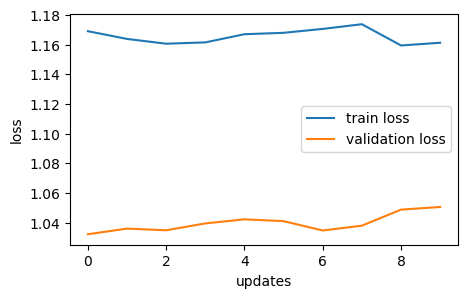

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'validation loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 7. Inference

### Preprocessing Function for Single Sentence Input

This function `process_text` is used to preprocess a single sentence for input to a BERT-based model.

### Input
- `sentence`: The input sentence to be processed.
- `tokenizer`: The tokenizer used to tokenize the sentence.
- `vocab`: The vocabulary containing token-to-index mappings.
- `max_seq_length`: The maximum sequence length expected by the model.

### Output
- A dictionary containing the preprocessed input:
  - `input_ids`: Tensor containing token IDs of the input sentence.
  - `attention_mask`: Tensor containing attention mask indicating which tokens are real and which are padding.

### Functionality
- Tokenizes the input sentence using the provided tokenizer.
- Converts tokens to token IDs using the provided vocabulary.
- Adds special tokens `[CLS]` and `[SEP]` to mark the beginning and end of the sentence.
- Adds padding tokens `[PAD]` to ensure the sequence length matches `max_seq_length`.
- Constructs an attention mask to distinguish real tokens from padding tokens.


In [42]:
def process_text(sentence, tokenizer, vocab, max_seq_length):
    tokens = tokenizer(re.sub("[.,!?\\-]", '', sentence.lower()))
    input_ids = [vocab['[CLS]']] + [vocab[token] for token in tokens] + [vocab['[SEP]']]
    n_pad = max_seq_length - len(input_ids)
    attention_mask = ([1] * len(input_ids)) + ([0] * n_pad)
    input_ids = input_ids + ([0] * n_pad)

    return {'input_ids': torch.LongTensor(input_ids).reshape(1, -1),
            'attention_mask': torch.LongTensor(attention_mask).reshape(1, -1)}

### Sentence Similarity Calculation Function

This function `calculate_similarity` is used to calculate the cosine similarity between two input sentences using a pretrained BERT-based model.

### Inputs
- `model`: The pretrained BERT-based model used for encoding sentences.
- `tokenizer`: The tokenizer used to tokenize the sentences.
- `vocab`: The vocabulary containing token-to-index mappings.
- `sentence_a`: The first input sentence.
- `sentence_b`: The second input sentence.
- `device`: The device (CPU or GPU) where the model will be executed.

### Output
- The cosine similarity score between the two input sentences.

### Functionality
- Tokenizes and converts the input sentences into input IDs and attention masks compatible with the BERT model.
- Extracts token embeddings for both sentences from the BERT model.
- Calculates the mean-pooled vectors for both sentences.
- Computes the cosine similarity between the mean-pooled vectors.



In [43]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(model, tokenizer, vocab, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = process_text(sentence_a, tokenizer, vocab, max_seq_length)
    inputs_b = process_text(sentence_b, tokenizer, vocab, max_seq_length)
    

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids'].to(device)
    attention_a = inputs_a['attention_mask'].to(device)
    inputs_ids_b = inputs_b['input_ids'].to(device)
    attention_b = inputs_b['attention_mask'].to(device)
    segment_ids = torch.zeros(1, max_seq_length, dtype=torch.int32).to(device)

    # Extract token embeddings from BERT
    u = model.get_last_hidden_state(inputs_ids_a, segment_ids)  # all token embeddings A = batch_size, seq_len, hidden_dim
    v = model.get_last_hidden_state(inputs_ids_b, segment_ids)  # all token embeddings B = batch_size, seq_len, hidden_dim

    # u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
    # v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

    # Get the mean-pooled vectors
    u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim
    v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim

    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]

    return similarity_score

In [44]:

sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(model, tokenizer, vocab, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.9240


In [31]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
max_len = max_seq_length
def cosine_similarity(u, v):
    """
    Compute the cosine similarity between two tensors.
    """
    dot_product = (u * v).sum()
    norm_u = u.norm(2)
    norm_v = v.norm(2)
    similarity = dot_product / (norm_u * norm_v)
    return similarity.item()

def calculate_average_cosine_similarity(model, data_loader, device):
    """
    Calculate the average cosine similarity between the sentence embeddings
    of pairs in the dataset.
    """
    model.eval()
    similarities = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Calculating Similarity', leave=False):
            inputs_ids_a = batch['premise_input_ids'].to(device)
            inputs_ids_b = batch['hypothesis_input_ids'].to(device)
            attention_a = batch['premise_attention_mask'].to(device)
            attention_b = batch['hypothesis_attention_mask'].to(device)
            segment_ids = torch.zeros(inputs_ids_a.size(0), max_len, dtype=torch.int32).to(device)

            u_last_hidden_state = model.get_last_hidden_state(inputs_ids_a, segment_ids)
            v_last_hidden_state = model.get_last_hidden_state(inputs_ids_b, segment_ids)

            u_mean_pool = mean_pool(u_last_hidden_state, attention_a)
            v_mean_pool = mean_pool(v_last_hidden_state, attention_b)

            similarity = cosine_similarity(u_mean_pool, v_mean_pool)
            similarities.append(similarity)

    average_similarity = np.mean(similarities)
    return average_similarity

# Assuming test_dataloader is already defined and contains the test dataset
# device is defined as per the previous context
average_similarity = calculate_average_cosine_similarity(model, test_dataloader, device)
average_similarity

Calculating Similarity:   0%|          | 0/3 [00:00<?, ?it/s]

0.929920494556427